# Mean Field Simulations - Slow Waves propagation on a whole emisphere

In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from pylab import *

We aim to reproduce in simulation the slow waves dynamics observe in a recording of a whole hemisphere of wild type mouse recordings. The Data are obtained through GECI calcium imaging GCaMP-6f. The native resolution is 50x50 µm2, but we downsampled to 100x100 µm2. The temporal resolution is dt = 40ms.

We arranged a grid of N $\simeq 1400$ populations of neuron. Each population is associated to a recorded pixel and is composed by two classes of neurons, excitatory neurons (regular spiking, RS) and inhibitory neurons (fast spiking, FS). The parameters describing these neurons are reported below.

| cell Type | $\theta$ (mV) | $\tau_m $ (ms)  | $C$ (nF) | $E_l $ (mV) |  $\Delta V $ (mV) | $\tau_i $ (ms) | $E_{i}$ (mV) | $Q_i$ (nS) | $b$ (nA)	| $\tau_W$ (s) |
|------|------|------|------|------|------|------|------|------|------|------|
|  RS 	| -50 | 20 | 0.2 | -65 | 2.0 | 5 | 0 | 1 | 0.005 | 0.5|
|FS 	| -50 |	 20 | 0.2 | -65 | 0.5 |5 | -80 | 5 | 0 | 0.5 |


The firing properties of such neurons are described by a transfer function. $\mathcal F(\mu_i(t),\sigma_i^2(t))$ is the transfer function that for an AdEx neuron, under stationary conditions, can be analitically expressed as the flux of realizations (i.e., the probability current) crossing the threshold  $V_{spike} = \theta + 5 \Delta V$  (see Tuckwell 1988):

\begin{eqnarray}
\mathcal{F}(\mu,\sigma) = &&\frac{1}{\sigma^2}\int_{-\infty}^{\theta + 5\Delta V} dV \int_{max(V,V_r)}^{\theta + 5\Delta V} du e^{-\frac{1}{\tau_m \sigma^2} \int_{V}^{u} [f(v) +\mu \tau_m]dv}.
\label{TF_cuBa}
\end{eqnarray} 
Where $f(v) = -(v(t)-E_l) + \Delta V e^{ ( \frac{v(t)-\theta}{\Delta V} )}$. 
$\tau_m$ the membrane time constant, $C$ the membrane capacitance, $E_l$ the reversal potential, $\theta$ the threshold, $\Delta V$ the exponential slope parameter.

The theoretical transfer function, with the parameters expressed in the table above, is tabulated for computational benefits, and reported below.


In [3]:
TFE = sio.loadmat('TFpy.mat')
TF = np.array(TFE['TFE'])
mu = np.array(TFE['mu'])

TF = TF.ravel()#np.reshape(TF, (20,1))
mu = mu.ravel()#np.reshape(mu, (20,1))

z = np.polyfit(mu, TF, 20)

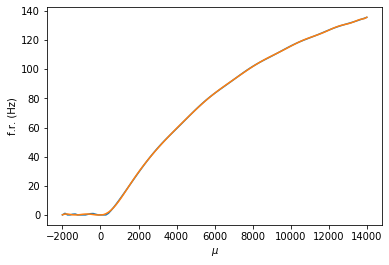

In [4]:
p = np.poly1d(z) 

def trasfFunc(p,mu):
    mu = np.maximum(mu,-2000)
    pp = p(mu)
    pp = np.minimum(pp,140)
    pp = np.maximum(pp,0)
    return pp

plt.plot(mu,TF)
plt.plot(mu,trasfFunc(p,mu))
plt.xlabel('$\mu$', fontdict=None, labelpad=None)
plt.ylabel('f.r. (Hz)', fontdict=None, labelpad=None)
plt.show()

Once defined the transfer function it is possible to define a dynamics for the system.

The probability at time $t+dt$ for a population $i$ to have a certain level of activity $S_i(t+dt)$ is assumed to be gaussian. In this case the average activity of the population $\nu(t+dt)$ at time $t+dt$ is computed as a function of its input by using a leaky integrate and fire response function

\begin{equation}
\lambda_i(t+dt) = \mathcal{F}[ \mu_i(t) ] : = \mathcal{F}_i(t)
\end{equation}

where $\mathcal F(\mu_i(t))$ is the transfer function that for an AdEx neuron and is a function of both the average of the input current and can be expressed as a function of the activity of other populations and of the local fatigue $W_i(t)$ as follows:

\begin{equation}
\mu_i(t) = \sum_k k_{ik} S_k(t) + I_{ext} - b_i W_i(t)
\end{equation}

This defines the mean fieldd dynamics togheter with the adaptation variable equation

\begin{equation}
\dot W_i(t) = -\frac{W_i(t)}{\tau_W} + S_i(t)
\end{equation}

The parameters necessary to obtain the correct dynamics are inferred from the Data.

In [5]:
#Simulations Parameters

dt = 0.04#(s)
tauW = 0.1#(s)

#load Inferred Parameters

InferredParameters = sio.loadmat('InferredParameters_py.mat')
K = np.transpose( np.array(InferredParameters['kLat']) ) 
b = np.array(InferredParameters['bs'])
Iext = np.transpose(np.array(InferredParameters['ExcDrive']))*.95

xPos = np.array(InferredParameters['x_pos_sel'])
yPos = np.array(InferredParameters['y_pos_sel'])


N = np.shape(Iext)[1]

In [6]:
TIME = 200
nuE = np.zeros((TIME,N),dtype=float)
muE = np.zeros((TIME,N),dtype=float)
W = np.zeros((TIME,N),dtype=float)

times = np.arange(TIME)*dt

for t in range(TIME-1):
    
    W[t+1,:] = W[t,:] + dt*( -W[t,:]/tauW + nuE[t,:] ) 
    
    muE[t,:] =  np.matmul(nuE[t,:],K) + Iext - W[t,:]*b
    
    TFE = trasfFunc(p,   muE[t,:] )  #    

  # nuE[t+1,:] = nuE[t,:] + dt/tau*( -nuE[t,:] + TFE ) 
    nuE[t+1,:] =   np.maximum(TFE + np.random.randn(1,N)*3,0)



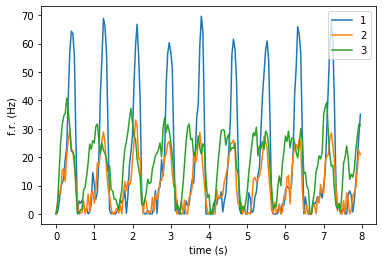

In [7]:
ndx1 = 10
ndx2 = 100
ndx3 = 1000

plt.plot(times,nuE[:,ndx1])
plt.plot(times,nuE[:,ndx2])
plt.plot(times,nuE[:,ndx3])
#plt.plot(times,W[:,ndx]/max(W[:,ndx])*max(nuE[:,ndx]))
plt.xlabel('time (s)')
plt.ylabel('f.r. (Hz)')
plt.legend('123')
plt.show()

In [8]:
Grid = np.zeros((50,50),dtype=float)

for t in range(1):#range(TIME-1)
    for k in range(N-1):
        Grid[xPos[0,k]-1,yPos[0,k]-1] = nuE[0,k]
    

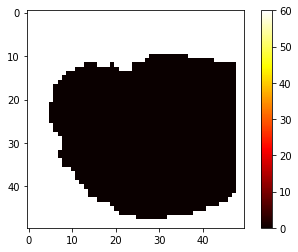

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

fig = plt.figure()

matrice = plt.imshow(Grid,cmap='hot', animated=True)
plt.clim(0,60)
plt.colorbar()

def update(i):
    Grid = np.zeros((50,50),dtype=float)+60
    for k in range(N-1):
        Grid[xPos[0,k]-1,yPos[0,k]-1] = nuE[i,k]
    matrice.set_array(Grid)

#fig, ax = plt.subplots()
#matrice = plt.imshow(Grid)
#plt.colorbar(matrice)

ani = animation.FuncAnimation(fig, update, frames=TIME, interval=100)
#plt.show()

ani.save('waves_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# Wavefront propagation Movie

In [14]:
HTML(ani.to_html5_video())